# AutoGluon Multimodal - Quick Start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/master/docs/tutorials/multimodal/multimodal_prediction/multimodal-quick-start.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/master/docs/tutorials/multimodal/multimodal_prediction/multimodal-quick-start.ipynb)

AutoGluon's `MultiModalPredictor` is a deep learning model zoo of model zoos that can automatically build state-of-the-art deep learning models for inputs including images, text, and tabular data. Convert your data into AutoGluon's multimodal dataframe format, and `MultiModalPredictor` can predict the values of one column based on the other features.

Begin by making sure AutoGluon is installed, and then import the required modules.

In [1]:
import os
import warnings

import numpy as np

warnings.filterwarnings('ignore')
np.random.seed(123)

## Example Data

For this tutorial we use a simplified and subsampled version of the [PetFinder dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). The goal is to predict pet adoption rates based on their adoption profiles. In this simplified version, the adoption speed is grouped into two categories: 0 (slow) and 1 (fast). We begin by downloading a zip file containing the petfinder datasets and unzipping them in the current working directory.

In [2]:
from autogluon.core.utils.loaders import load_zip

download_dir = './ag_multimodal_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'

load_zip.unzip(zip_file, unzip_dir=download_dir)

Next, we use pandas to read the dataset's CSV files into `DataFrames`, noting that the column we are interested in learning to predict is "AdoptionSpeed".

In [3]:
import pandas as pd

dataset_path = f'{download_dir}/petfinder_for_tutorial'

train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)

label_col = 'AdoptionSpeed'

The PetFinder dataset comes with a directory of images, and some records in the data have multiple images associated with them. AutoGluon's multimodal dataframe format requires that image columns contain a string whose value is a path to a single image file. For this example, we will limit the image feature column to only the first image and will need to do some path manipulations to get everything setup correctly for the current directory structure.

In [4]:
image_col = 'Images'

train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0])
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])

def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

Each animal's adoption profile includes pictures, a text description, and various tabular features such as age, breed, name, color, and more. Let's look at a picture and description for an example row of data.

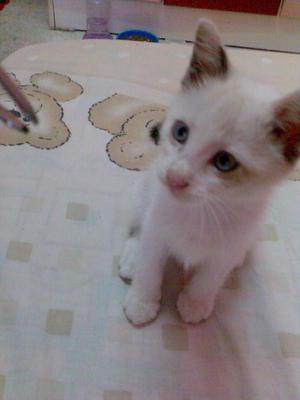

"I rescued Yumi Hamasaki at a food stall far away in Kelantan. At that time i was on my way back to KL, she was suffer from stomach problem and looking very2 sick.. I send her to vet & get the treatment + vaccinated and right now she's very2 healthy.. About yumi : - love to sleep with ppl - she will keep on meowing if she's hugry - very2 active, always seeking for people to accompany her playing - well trained (poo+pee in her own potty) - easy to bathing - I only feed her with these brands : IAMS, Kittenbites, Pro-formance Reason why i need someone to adopt Yumi: I just married and need to move to a new house where no pets are allowed :( As Yumi is very2 special to me, i will only give her to ppl that i think could take care of her just like i did (especially on her foods things).."

In [5]:
example_row = train_data.iloc[0]
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

example_row['Description']

## Training

Now that the data is in a suitable format, we can fit `MultiModalPredictor` on the training data. Here we set a tight training time budget for this quick demo. More training time will lead to better prediction performance, but we can get surprisingly good performance in a short amount of time.

In [4]:
from autogluon.multimodal import MultiModalPredictor

predictor = MultiModalPredictor(label=label_col).fit(
    train_data=train_data,
    time_limit=120
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250604_175332"
=================== System Info ===================
AutoGluon Version:  1.3.2b20250604
Python Version:     3.10.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:49 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T6000
CPU Count:          10
Pytorch Version:    2.6.0
CUDA Version:       CUDA is not available
GPU Count:          1
Memory Avail:       18.99 GB / 32.00 GB (59.3%)
Disk Space Avail:   37.96 GB / 460.43 GB (8.2%)
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [np.int64(0), np.int64(1)]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Under the hood `MultiModalPredictor` automatically infers the problem type (classification or regression), detects feature modalities, selects models from the multimodal model pools, and trains the selected models. If multiple backbones are used, MultiModalPredictor appends a late-fusion model (MLP or transformer) on top of them.

## Prediction

After fitting the model, we want to use it to predict the labels in the witheld test dataset.

In [ ]:
predictions = predictor.predict(test_data.drop(columns=label_col))
predictions[:5]

For classification tasks, we can just as easily get the prediction probabilities for each output class.

In [ ]:
probs = predictor.predict_proba(test_data.drop(columns=label_col))
probs[:5]

## Evaluation

Finally, we can evaluate the predictor on the witheld test dataset on other performance metrics, in this case [roc_auc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [ ]:
scores = predictor.evaluate(test_data, metrics=["roc_auc"])
scores

## Conclusion

In this quickstart tutorial we saw the basic fit and predict functionality of AutoGluon's `MultiModalPredictor`, but we just scratched the surface on its functionality. Check out the in-depth tutorials to learn about other features of AutoGluon's `MultiModalPredictor` like embedding extraction, distillation, model fine-tuning, text or image prediction, and semantic matching.